In [ ]:
from PIL import Image 
import PIL 
from edsra import edsr
from common import resolve_single
from utils import load_image, plot_sample
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import numpy as np
scale = 4
depth = 16
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights('sgan_weights.h5')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import imageio
import scipy, scipy.misc, scipy.signal
import cv2
import sys
import random 

#HISTOGRAM EQUALIZATION ALGORITHM 
def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]

    
    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2,2:wid+2]
    i = I[2:hei+2,2:wid+2].astype(np.uint8)
    
    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

def dhe(img, alpha=0.5):
    
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

def dhea(image_path):
    img_name = sys.argv[1]
    img = imageio.imread(image_path)
    result = dhe(img)
   
    rand = random.randint(2000,2500)
    a1= str(rand)
    b1= ".png"
    c1=str(a1+b1)
    cv2.imwrite(c1, result)
    plt.show()
    return c1

image_paths = "0829x4-crop.png"
ans = image_paths
print(ans)

0829x4-crop.png


<ipython-input-12-d85d31e5af08>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(image_paths)


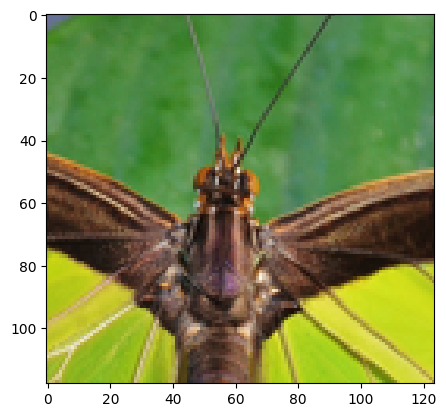

In [ ]:
import random

# Resizing and predicting SGAN Output 
# Adding sharpness to image  using 2D Conv Filter 



kernel3 = np.array([[0, -1,  0],
                   [-1,  5, -1],
                    [0, -1,  0]])



img1 = imageio.imread(image_paths)
low_light_img = Image.open(image_paths).convert('RGB')
plt.imshow(img1)
def resolve_and_plot(lr_image_path):
    lr = cv2.imread(lr_image_path)  
    down_points = (118, 118)
    lrr = resized_down = cv2.resize(lr, down_points, interpolation= cv2.INTER_LINEAR)
    
    sr = resolve_single(model,lrr)
    
    rand = random.randint(0,100)
    a= str(rand)
    b= ".jpg"
    c=str(a+b)
    plot_sample(lr, sr)
    plt.savefig(c)
    return c

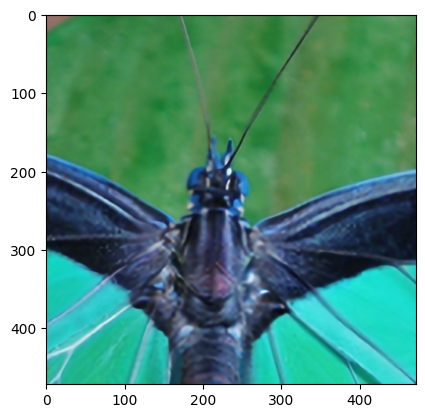

In [ ]:
lr = cv2.imread(ans)  
down_points = (118, 118)
lrr = resized_down = cv2.resize(lr, down_points, interpolation= cv2.INTER_LINEAR)
sr = resolve_single(model,lrr)
plt.imshow(sr)
rand = random.randint(500,1000)
aa= str(rand)
bb= ".jpg"
cc=str(aa+bb)
plt.savefig(cc)

config.json not found in HuggingFace Hub.


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

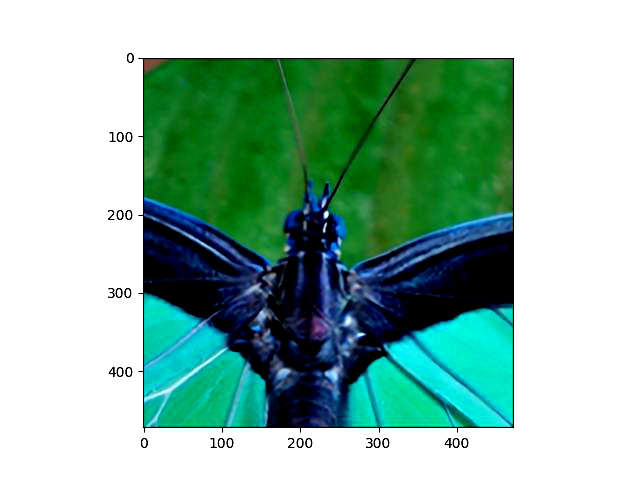

In [ ]:
from PIL import Image, ImageOps,ImageEnhance
img = Image.open(cc)

import numpy as np 
from huggingface_hub import from_pretrained_keras 
import keras 
from PIL import Image 
import tensorflow as tf
enhacer = from_pretrained_keras("keras-io/lowlight-enhance-mirnet", compile=False) 


enhancer = ImageEnhance.Contrast(img)
factor = 1.5
im_output = enhancer.enhance(factor)
enhancer1 = ImageEnhance.Brightness(im_output)
factor1 = 0.5
im_output1 = enhancer1.enhance(factor1)


enhancer2 = ImageEnhance.Color(im_output1)
factor1 = 1.5

im_output2 = enhancer.enhance(factor)

im_output2
